# TWIGL 2D reactor: multigroup Neutron Diffusion
This notebook implements the 2D TWIGL reactor, based on the paper *Comparison of Alternating- Direction Time-Differencing Methods with Other Implicit Methods for the Solution of the Neutron Group-Diffusion Equations* (L. A. Hageman and J. B. Yasinsky, 1968).

In [1]:
from dolfinx.io import gmshio
import gmsh
from mpi4py import MPI
from IPython.display import clear_output

import numpy as np
import ufl
from dolfinx.fem import (Function)

import matplotlib.pyplot as plt
from matplotlib import cm

import warnings
warnings.filterwarnings("ignore")

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

## Preamble
The geometry and the main physical parameters will be assigned.

### Mesh Import
The geometry and the mesh are imported from "TWIGL2D.msh", generated with GMSH.

In [2]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = 1

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge(mesh_path+'TWIGL2D.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")
clear_output()

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
domain1_marker = 10
domain2_marker = 20
domain3_marker = 30

boundary_marker = 1

tdim = domain.topology.dim
fdim = tdim - 1

ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
dx = ufl.Measure("dx", domain=domain)

domain.topology.create_connectivity(fdim, tdim)

### Define parameter functions on the different regions
Since there are 3 subdomains in $\Omega$ (i.e., fuel-1, fuel-2,  fuel-3) the values of the parameters changes according to the region, therefore proper functions should be defined.

In [3]:
regions = [domain1_marker, domain2_marker, domain3_marker]    

neutronics_param = dict()

neutronics_param['Energy Groups'] = 2

neutronics_param['D'] = [np.array([1.4, 1.4, 1.3]),
                         np.array([0.4, 0.4, 0.5])]
neutronics_param['xs_a'] = [np.array([0.01, 0.01, 0.008]),
                            np.array([0.15, 0.15, 0.05])]
neutronics_param['nu_xs_f'] = [np.array([0.007, 0.007, 0.003]),
                               np.array([0.2, 0.2, 0.06])]
neutronics_param['chi'] = [np.array([1,1,1]),
                           np.array([0,0,0])]
neutronics_param['B2z'] = [np.array([0,0,0]),
                           np.array([0,0,0])]
neutronics_param['xs_s'] = [[np.array([0,0,0]), np.array([0.01, 0.01, 0.01])],
                            [np.array([0,0,0]), np.array([0,0,0])]]

nu_value = 2.43
Ef = 1
reactor_power = 1

## Solution of the eigenvalue problem
The MG diffusion equation is discretised using the Finite Element Method, and its eigenvalue formulation is solved through the standard inverse-power method.

In [4]:
from neutronics.neutr_diff import steady_neutron_diff

neutr_steady_problem = steady_neutron_diff(domain, ct, ft, neutronics_param, regions, boundary_marker)
neutr_steady_problem.assembleForm()

# Solving the steady problem
phi_ss, k_eff = neutr_steady_problem.solve(power = reactor_power, Ef=Ef, nu = nu_value, 
                                           LL = 10, maxIter = 500, verbose=True)

    Iter 010 | k_eff: 0.912975 | Rel Error: 1.046e-04
    Iter 020 | k_eff: 0.913202 | Rel Error: 4.514e-06
    Iter 030 | k_eff: 0.913214 | Rel Error: 3.149e-07
    Iter 040 | k_eff: 0.913215 | Rel Error: 2.327e-08
    Iter 050 | k_eff: 0.913215 | Rel Error: 1.730e-09
    Iter 060 | k_eff: 0.913215 | Rel Error: 1.287e-10
    Neutronics converged with 061 iter | k_eff: 0.91321502 | rho: -9503.24 pcm | Rel Error: 9.923e-11


ld: warning: duplicate -rpath '/Users/stefanoriva/miniconda3/envs/mp/lib' ignored
ld: warning: duplicate -rpath '/Users/stefanoriva/miniconda3/envs/mp/lib' ignored


## Post-processing
The solution of the eigenvalue problem is compared with reference data.

Let us compare the $k_{eff}$ with the benchmark value

In [5]:
print('Computed  k_eff = {:.5f}'.format(k_eff))
print('Benchmark k_eff = {:.5f}'.format(0.91321))
print('Relative error  = {:.5f}'.format(np.abs(k_eff - 0.91321) / 0.91321 * 1e5)+' pcm')

Computed  k_eff = 0.91322
Benchmark k_eff = 0.91321
Relative error  = 0.55020 pcm


Let us plot the solution against benchmark data along the diagonal $x=y$ and along the $x$-axis $y=0$.

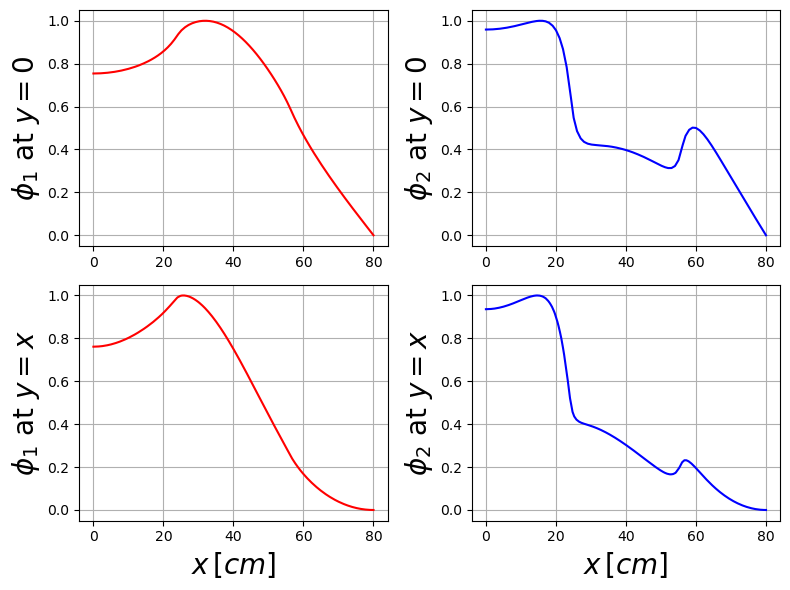

In [6]:
from plotting import extract_cells

Nhplot = 1000
xMax = 80
x_line = np.linspace(0, xMax + 1e-20, Nhplot)
points = np.zeros((3, Nhplot))
points[0] = x_line
xPlot_0, cells_0 = extract_cells(domain, points)
points[1] = x_line
xPlot_1, cells_1 = extract_cells(domain, points)

fluxFigure = plt.figure( figsize = (8,6) )

plt.subplot(2,2,1)
plt.plot(xPlot_0[:,0], phi_ss[0].eval(xPlot_0, cells_0) / max(phi_ss[0].eval(xPlot_0, cells_0)), 'r', label = r'dolfinx')
  
plt.ylabel(r"$\phi_1$ at $y=0$",fontsize=20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(2,2,2)
plt.plot(xPlot_0[:,0], phi_ss[1].eval(xPlot_0, cells_0) / max(phi_ss[1].eval(xPlot_0, cells_0)), 'b', label = r'dolfinx')
  
plt.ylabel(r"$\phi_2$ at $y=0$",fontsize=20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(2,2,3)
plt.plot(xPlot_1[:,0], phi_ss[0].eval(xPlot_1, cells_1) / max(phi_ss[0].eval(xPlot_1, cells_1)), 'r', label = r'dolfinx')
  
plt.xlabel(r"$x\,[cm]$",fontsize=20)
plt.ylabel(r"$\phi_1$ at $y=x$",fontsize=20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.subplot(2,2,4)
plt.plot(xPlot_1[:,0], phi_ss[1].eval(xPlot_1, cells_1) / max(phi_ss[1].eval(xPlot_1, cells_1)), 'b', label = r'dolfinx')
  
plt.xlabel(r"$x\,[cm]$",fontsize=20)
plt.ylabel(r"$\phi_2$ at $y=x$",fontsize=20)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')

plt.tight_layout()

Let us know display the fluxes contour plots.

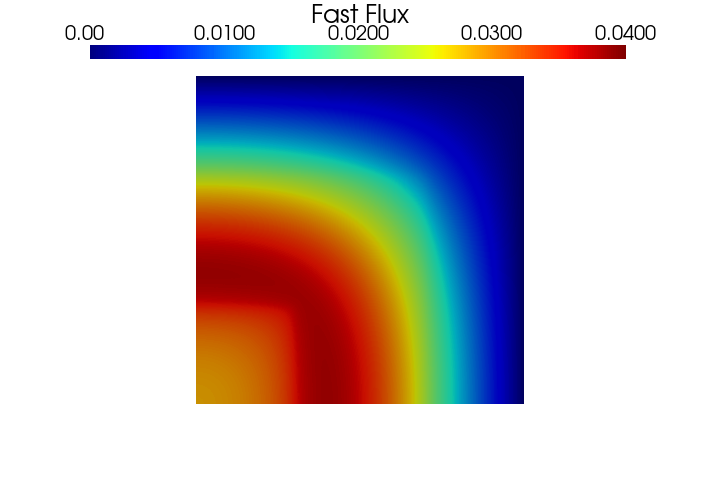

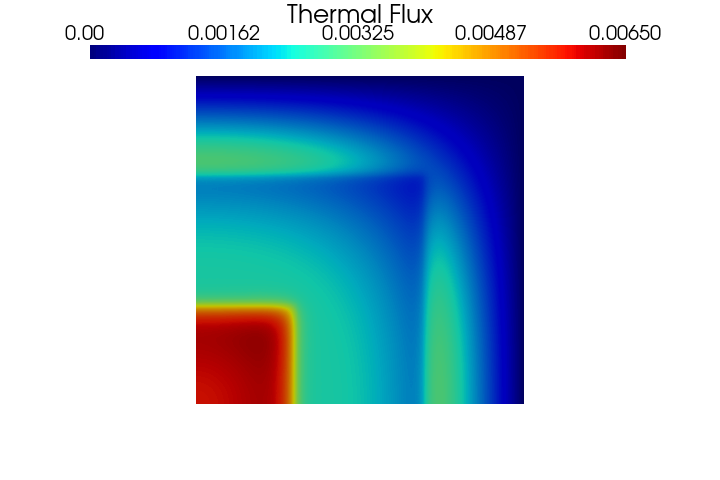

In [7]:
from plotting import PlotScalar

PlotScalar(phi_ss[0], show=True, varname='Fast Flux', resolution=[720, 480], clim=[0, 0.04])
PlotScalar(phi_ss[1], show=True, varname='Thermal Flux', resolution=[720, 480], clim=[0, 0.0065])

In [20]:
import pyvista as pv
from plotting import get_scalar_grid

def subPlot_flux(fast: Function, thermal: Function, time = None,
                 filename: str = None, clim = None, 
                 cmap1 = cm.viridis, cmap2 = cm.magma, resolution = [1400, 600]):

    plotter = pv.Plotter(shape=(1,2), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 25
    zoom = 1.1
    
    dict_cb = dict(title = ' ', width = 0.76,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    color='k',
                    position_x=0.12, position_y=0.89,
                    shadow=True) 

    clim_scale = .01
    
    ################### Fast Flux ###################
    plotter.subplot(0,0)
    if clim is None:    
        clim1 = [0,  max(fast.x.array) * (1+clim_scale)]
    dict_cb['title'] = 'Fast Flux'
    plotter.add_mesh(get_scalar_grid(fast, varname='phi1'), cmap = cmap1, clim = clim1, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    ################### Thermal Flux ###################
    plotter.subplot(0,1)
    if clim is None:
        clim2 = [0,  max(thermal.x.array) * (1+clim_scale)]
    dict_cb['title'] = 'Thermal Flux'
    plotter.add_mesh(get_scalar_grid(thermal, varname='phi2'), cmap = cmap2, clim = clim2, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    
    ###### Save figure ######
    
    plotter.set_background('white', top='white')
    plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
    plotter.close()

In [21]:
subPlot_flux(phi_ss[0], phi_ss[1], filename='twigl-ss-contour')